In [1]:
import warnings
import pickle
import sys
import numpy as np
warnings.filterwarnings('ignore')

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
sys.path.append('../datawrangling')

# import modules
import visualize
import geometry_utils
import dataloader_paths, dataloader_geo

from maritime_traffic_network import MaritimeTrafficNetwork
from random_path_prediction import RandomWalkPathPrediction
import prediction_model_evaluation_metrics as metrics

In [2]:
# Load a model from pickle
datasize = 'full'
location = 'stavanger'
model_date = '202204'
train_dates = ['202205']
test_dates = ['202206']
DP_tol = 30
min_samples = 25

network_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
network_path = '../../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_stavanger_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 30,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 25,
 'clustering_min_cluster_size': 25,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45,
 'merge_stops_speed': 2}

In [3]:
# Load training data from file
path_prefix = '../../data/paths/'
training_paths = dataloader_paths.load_path_training_data(path_prefix, network_name, train_dates, data_version='')

In [4]:
# train model
model = RandomWalkPathPrediction()
model.train(network.G_pruned, training_paths)

In [5]:
out_degrees = dict(network.G.out_degree())
# Calculate the average out-degree
average_out_degree = sum(out_degrees.values()) / len(out_degrees)
print(average_out_degree)

4.972748815165877


In [6]:
# Load test data from file
path_prefix = '../../data/paths/'
traj_path_prefix = '../../data/processed/'
all_test_paths = dataloader_paths.load_path_test_data(path_prefix, network_name, test_dates, 
                                                      0, -1, 1)
test_trajectories = dataloader_geo.load_trajectories(traj_path_prefix, location, network.crs, test_dates)

In [59]:
######## SET PREDICTION PARAMETERS ##########
n_start_nodes = 1
n_steps = 5
n_walks = 1000
n_predictions = 1
#############################################

In [60]:
# split test paths in subpaths
sub_paths = dataloader_paths.split_path_data(all_test_paths, n_steps+1)

selection_start = 0
selection_end = -1
selection_step = 80
if selection_end == -1:
    selection_end = len(sub_paths)
selection = np.arange(selection_start, selection_end, selection_step)

test_paths = sub_paths.iloc[selection]

In [61]:
# MAKE PREDICTIONS
predictions = model.predict(test_paths, n_start_nodes, n_steps, n_predictions, n_walks, method='weighted')
for i in range(0, len(predictions)):
    node_sequence = predictions['prediction'].iloc[i]
    if not geometry_utils.is_valid_path(network.G, node_sequence):
        print(i)

Evaluating 1325 samples for next_nodes prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 0.39 minutes


Percentage of unsuccessful predictions: 0.00%
Mean SSPD: 738.96m
Median SSPD: 41.22m
Mean choice_accuracy: 0.6050


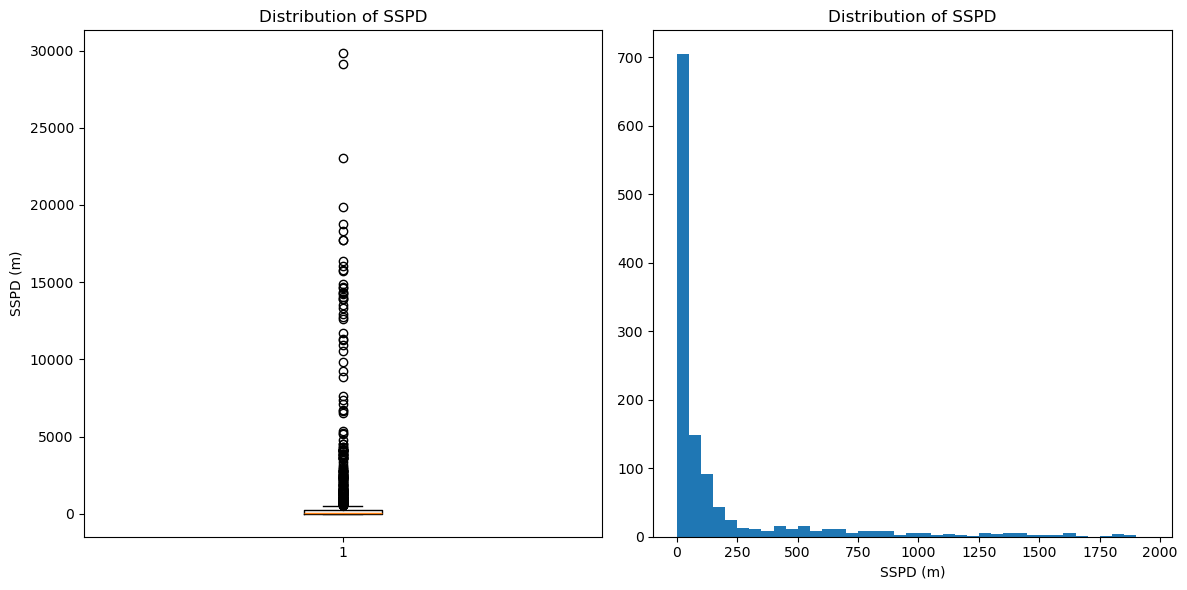

In [62]:
# evaluate
eval_mode = 'paths'
evaluation_results, fig = metrics.evaluate_given_predictions('next_nodes', predictions, test_trajectories, 
                                                             network, n_start_nodes=n_start_nodes, n_steps=n_steps, 
                                                             eval_mode=eval_mode)

In [63]:
# make predictions with the model and plot
i = 2
example = test_paths.iloc[i]
mmsi = example.mmsi
start_node = [example.path[0]]
true_path = example.path
trajectory = test_trajectories.get_trajectory(mmsi)

predictions = model.sample_paths(start_node, n_walks, n_steps)
total_sum = sum(predictions.values())
probabilities = {key: value / total_sum for key, value in predictions.items()}
for key in predictions:
    predictions[key] = probabilities[key]

map = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, 
                                                min_passages=2, opacity=0.2, location=location)
map.save('../../reports/maps/'+network_name+'_random_predictions.html')
print(f'Map saved under {"../../reports/maps/"+network_name+"_random_predictions.html"}')

Map saved under ../../reports/maps/202204_waypoints_DP30_HDBSCAN25_stavanger_full_UTM_random_predictions.html
